# Домашнее задание 5. Градиентный спуск. (10 баллов + 2 балла бонус)

В этом домашнем задании вы реализуете градиентный спуск для линейной регрессии, а также изучите, как он ведёт себя при разных параметрах и с разными функциями потерь.

Правила:

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания всем участникам нарушения будет выставлено 0 баллов, независимо от того, кто у кого списывал.

* Старайтесь сделать код максимально оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, рассмотренных в курсе.  

In [1]:
from typing import Iterable, List, Tuple

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

from tqdm.notebook import tqdm

## Часть 1. Градиентный спуск (5 баллов)

Для начала давайте вспомним самый простой функционал ошибки, который мы применяем в задаче регрессии — **Mean Squared Error (MSE)**:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — это $i$-ый объект датасета, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса нашей линейной модели.

Как мы помним, для линейной модели его можно записать в матричном виде вот так:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

где $X$ — это матрица объекты-признаки, а $y$ — вектор правильных ответов.

Чтобы воспользоваться методом градиентного спуска, нам нужно посчитать градиент нашего функционала. Для MSE он будет выглядеть так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

Ниже приведён базовый класс `BaseLoss`, который мы будем использовать для реализации всех наших лоссов. Менять его **не нужно**. У него есть два абстрактных метода:
1. Метод `calc_loss`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения лосса.
2. Метод `calc_grad`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять градиент функции потерь по параметрам модели.

In [2]:
import abc


class BaseLoss(abc.ABC):
    """Базовый класс лосса"""

    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число - значения функции потерь
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        raise NotImplementedError

Теперь давайте напишем реализацию этого абстрактного класса: Mean Squared Error лосс.

**Задание 1.1 (5/8 балла):** Реализуйте класс `MSELoss`.

Он должен вычислять лосс и градиент по формулам наверху.

In [3]:
class MSELoss(BaseLoss):
    def check_params(
            self,
            X: np.ndarray | pd.DataFrame,
            y: np.ndarray | pd.Series,
            w: np.ndarray | pd.Series) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Функция для проверки параметров методов calc_loss и calc_grad
        :param X: np.ndarray или pd.DataFrame размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray или pd.Series размера (n_objects,) с правильными ответами
        :param w: np.ndarray или pd.Series размера (n_features,) с весами линейной регрессии
        """

        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        if isinstance(y, pd.Series):
            y = y.to_numpy()
        if isinstance(w, pd.Series):
            w = w.to_numpy()

        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray) and isinstance(w, np.ndarray)

        assert len(X.shape) == 2 and len(y.shape) == 1 and len(w.shape) == 1
        assert X.shape[0] == y.shape[0] and X.shape[1] == w.shape[0]

        assert X.dtype == y.dtype == w.dtype

        assert not np.isnan(X).any() and not np.isnan(y).any() and not np.isnan(w).any()
        assert not np.isinf(X).any() and not np.isinf(y).any() and not np.isinf(w).any()

        return X, y, w

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """

        X, y, w = self.check_params(X, y, w)

        return np.square(np.linalg.norm(X @ w - y)) / X.shape[0]

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """

        X, y, w = self.check_params(X, y, w)

        return X.T @ (X @ w - y) * 2.0 / X.shape[0]

Теперь мы можем создать объект `MSELoss` и при помощи него вычислять значение нашей функции потерь и градиенты:

In [4]:
# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(
    loss.calc_grad(X, y, w),
    np.array(
        [
            1163180.0,
            1172281.0,
            1181382.0,
            1190483.0,
            1199584.0,
            1208685.0,
            1217786.0,
            1226887.0,
            1235988.0,
            1245089.0,
        ]
    ),
), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Теперь когда у нас есть всё для вычисления градиента, давайте напишем наш градиентный спуск. Напомним, что формула для одной итерации градиентного спуска выглядит следующим образом:

$$
w^{t+1} = w^{t} - \eta \nabla_{w} Q(w^{t}, X, y)
$$

Где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр learning rate, отвечающий за размер шага.

**Задание 1.2 (5/8 балла):** Реализуйте функцию `gradient_descent`.

Функция должна принимать на вход начальное значение весов линейной модели `w_init`, матрицу объектов-признаков `X`,
вектор правильных ответов `y`, объект функции потерь `loss`, размер шага `lr` и количество итераций `n_iterations`.

Функция должна реализовывать цикл, в котором происходит шаг градиентного спуска (градиенты берутся из `loss` посредством вызова метода `calc_grad`) по формуле выше, и возвращать
траекторию спуска (список из новых значений весов на каждом шаге).

In [5]:
def gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    n_iterations: int = 100000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) - начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) - матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) - вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param n_iterations: int --сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) - история весов на каждом шаге
    """

    weights = [w_init.copy()]

    for _ in range(n_iterations):
        grad = loss.calc_grad(X, y, weights[-1])
        weights.append(weights[-1] - lr * grad)

    return weights

Теперь создадим синтетический датасет и функцию, которая будет рисовать траекторию градиентного спуска по истории.

In [6]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :] # разные масштабы признаков
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [7]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

425.5891768045025
0.8670644395649494


In [8]:
def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss, title: str = "GD trajectory"):
    """
    Функция для отрисовки траектории градиентного спуска
    :param w_list: Список из объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать лосс при помощи loss.calc_loss(X, y, w)
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(5, 5))
    plt.title(title)
    plt.xlabel(r"$w_1$")
    plt.ylabel(r"$w_2$")
    plt.xlim(w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect("auto")

    # Отображение уровня функции потерь
    CS = plt.contour(
        A, B, levels, levels=np.logspace(0, 2, num=20), cmap=plt.cm.rainbow_r
    )
    CB = plt.colorbar(CS, shrink=0.8, extend="both")

    # Отображение траектории спуска
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

**Задание 1.3 (5/8 балла):** При помощи функций `gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`). Используйте четыре и более различных значений для `lr`.

Сделайте и опишите свои выводы о том, как параметр `lr` влияет на поведение градиентного спуска.

Подсказки:
* Функция `gradient_descent` возвращает историю весов, которую нужно подать в функцию `plot_gd`.
* Хорошие значения для `lr` могут лежать в промежутке от 0.0001 до 0.1.

learning rate = 0.015


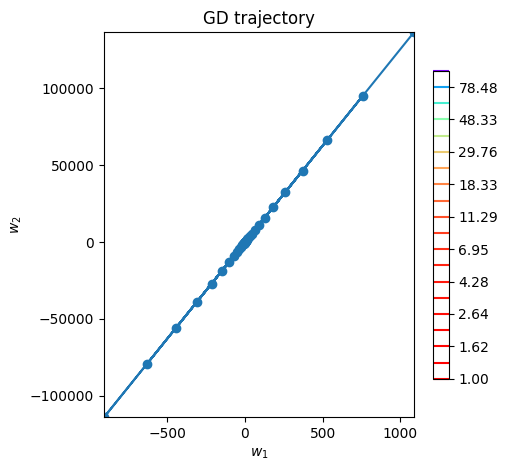

learning rate = 0.0125


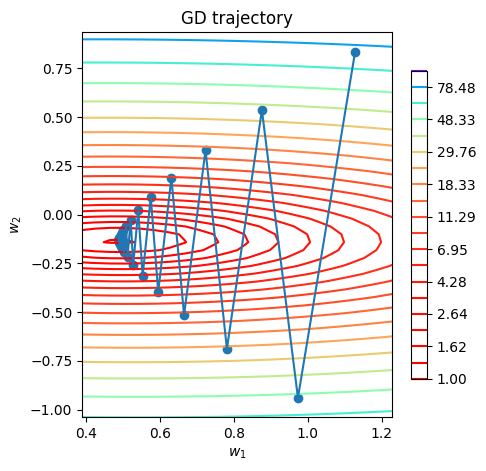

learning rate = 0.01


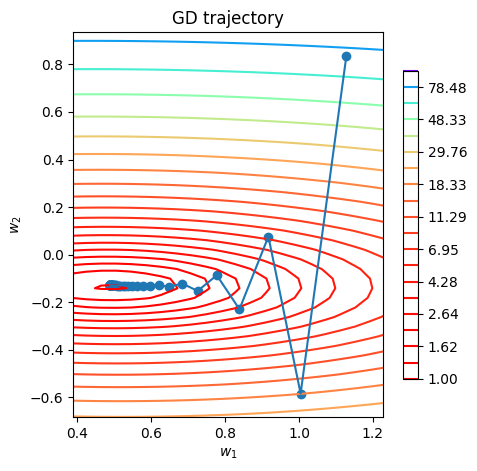

learning rate = 0.001


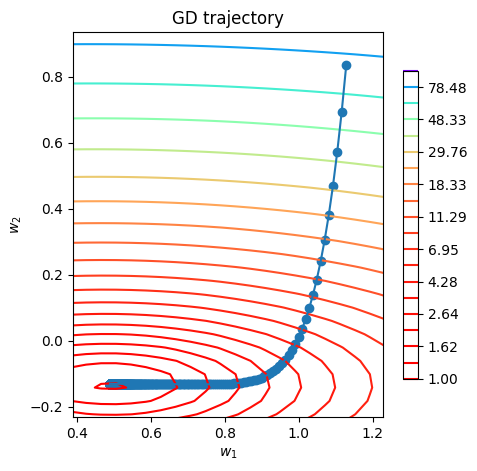

learning rate = 0.0001


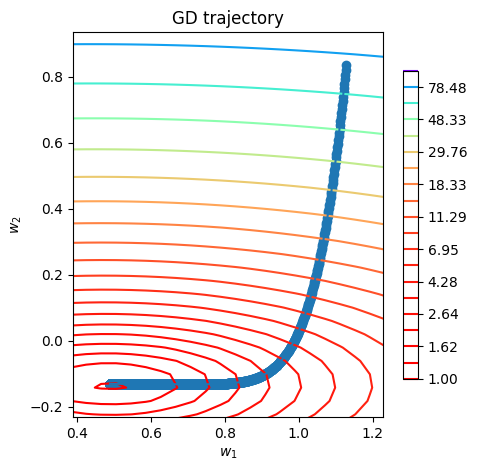

In [9]:
np.random.seed(42)

n_features = 2
n_objects = 500
w_true = np.random.normal(size=(n_features,))
X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))
loss = MSELoss()

lr_values = [0.015, 0.0125, 0.01, 0.001, 0.0001]

for lr in lr_values:
    print(f"learning rate = {lr}")
    w_list = gradient_descent(w_init, X, y, loss, lr, int(1 / lr))
    plot_gd(w_list, X, y, loss)

**Вывод:** параметр learning_rate определяет скорость сходимости градиентного спуска.

Слишком большие значения _lr_ приводят к "взрыву" градиента, когда каждая итерация вместо приближения к точке минимума проскакивает её и в итоге решение становится всё хуже и хуже (лосс только растёт).

Слишком низкие значения _lr_ просто потребуют большего количества итераций, но зато точно не произойдёт "проскока" точки минимума функции потерь слишком рано, как при "взрыве" градиента.

Теперь реализуем стохастический градиентный спуск.

**Задание 1.4 (5/8 балла):** Реализуйте функцию `stochastic_gradient_descent`.

Функция должна принимать все те же параметры, что и функция `gradient_descent`, но ещё параметр `batch_size`, отвечающий за размер батча.

Функция должна как и раньше реализовывать цикл, в котором происходит шаг градиентного спуска, но на каждом шаге считать градиент не по всей выборке `X`, а только по случайно выбранной части.

Подсказка: для выбора случайной части можно использовать [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) с правильным параметром `size`, чтобы выбрать случайные индексы, а потом проиндексировать получившимся массивом массив `X`:
```
batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
batch = X[batch_indices]
```

In [10]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """

    weights = [w_init.copy()]

    for _ in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        batch = X[batch_indices]
        grad = loss.calc_grad(batch, y[batch_indices], weights[-1])
        weights.append(weights[-1] - lr * grad)

    return weights

**Задание 1.5 (5/8 балла):** При помощи функций `stochastic_gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`) и размера подвыборки (параметра `batch_size`). Используйте не менее четырёх разных значений для `lr` и `batch_size`.

Сделайте и опишите свои выводы о том, как параметры  `lr` и `batch_size` влияют на поведение стохастического градиентного спуска. Как отличается поведение стохастического градиентного спуска от обычного? Что происходит при малых и больших `batch_size`?

Обратите внимание, что в нашем датасете всего 300 объектов, так что `batch_size` больше этого числа не будет иметь смысла.

learning rate = 0.015
batch size = 1
final loss = 5.312999892382216e+145


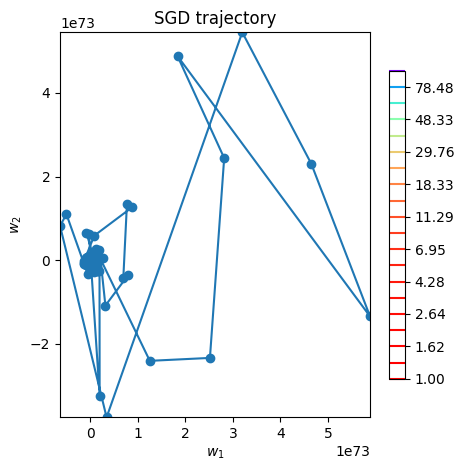

learning rate = 0.015
batch size = 2
final loss = 110733602.99512742


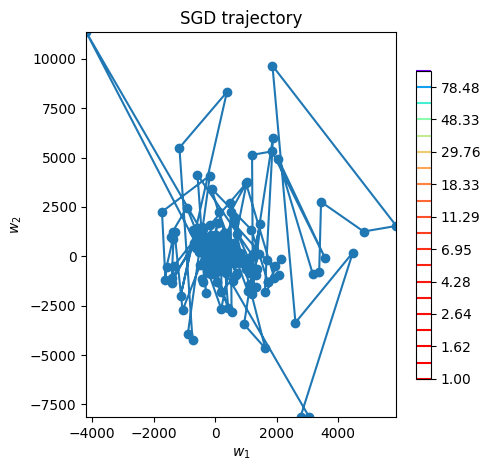

learning rate = 0.015
batch size = 5
final loss = 3.366750920246113


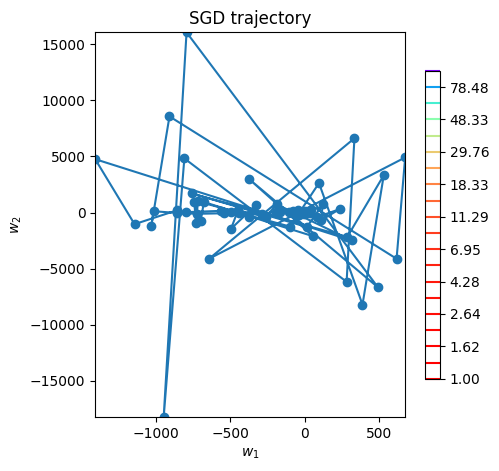

learning rate = 0.015
batch size = 10
final loss = 1.3504299726259181


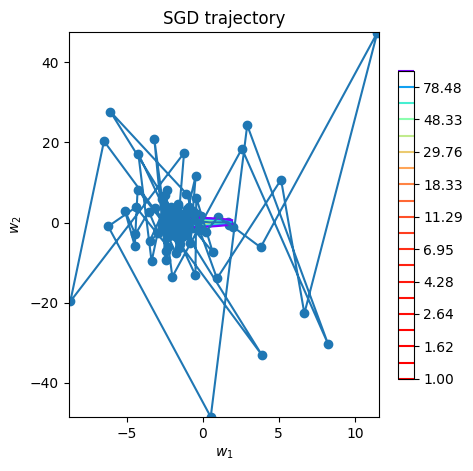

learning rate = 0.015
batch size = 20
final loss = 1.1211123864886834


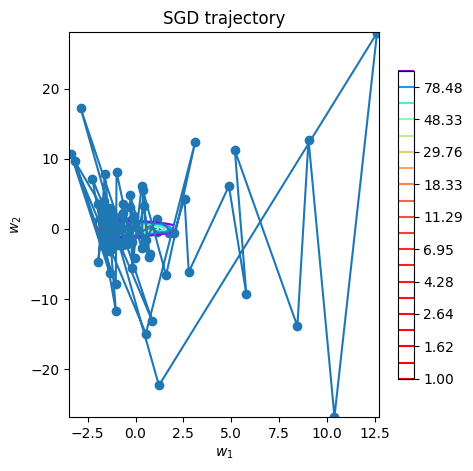

learning rate = 0.015
batch size = 50
final loss = 9.8724458850075e+25


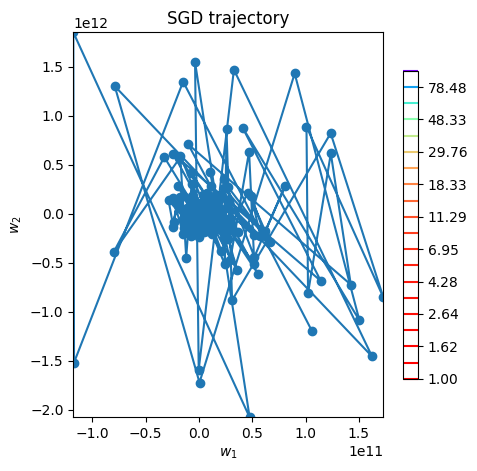

learning rate = 0.015
batch size = 100
final loss = 3.4808235974369915e+39


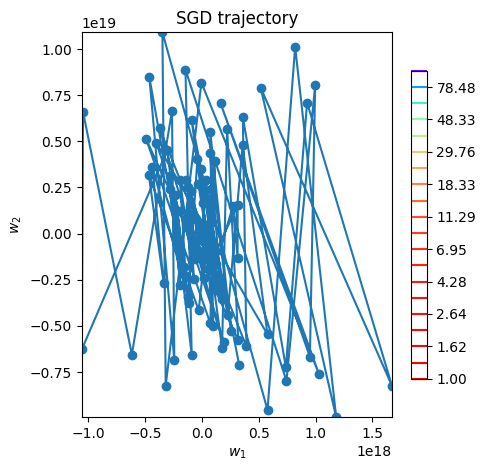

learning rate = 0.015
batch size = 200
final loss = 5.573394162732462e+50


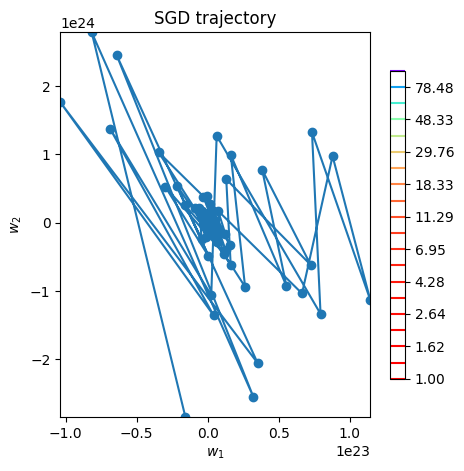

learning rate = 0.015
batch size = 300
final loss = 5.687392025230276e+53


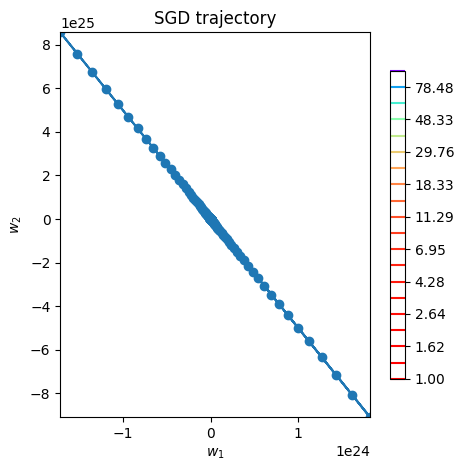

learning rate = 0.0125
batch size = 1
final loss = 1.9518383001907892e+37


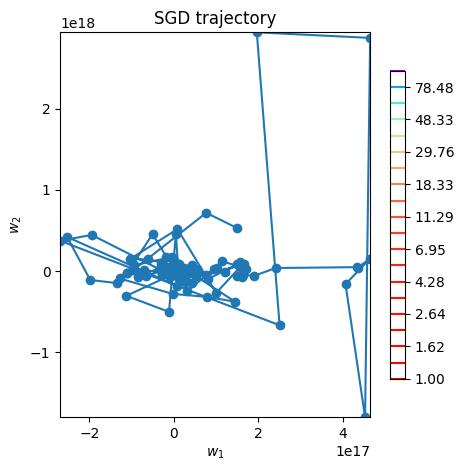

learning rate = 0.0125
batch size = 2
final loss = 52.932813650295394


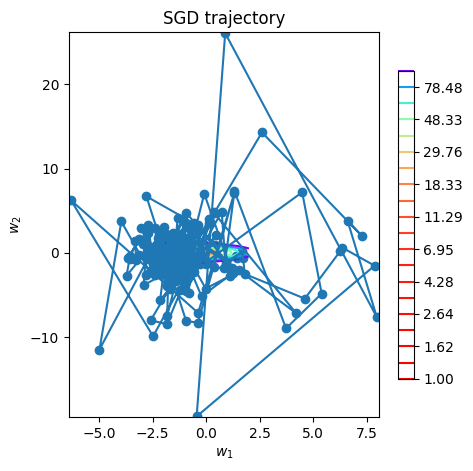

learning rate = 0.0125
batch size = 5
final loss = 6.0730323914734585


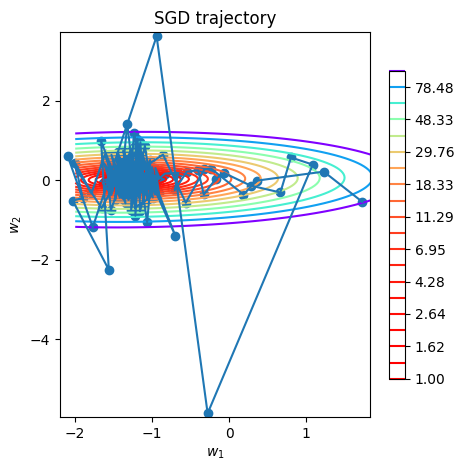

learning rate = 0.0125
batch size = 10
final loss = 2.119731081096245


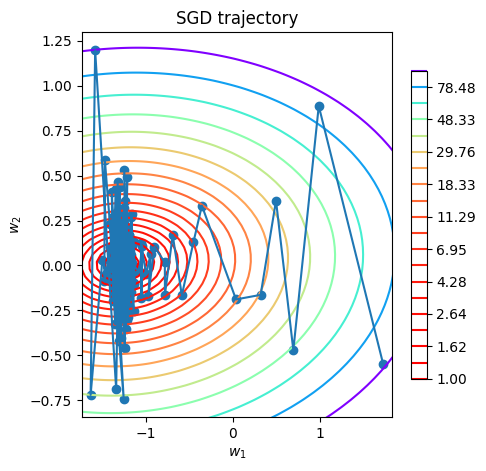

learning rate = 0.0125
batch size = 20
final loss = 1.1905528141185038


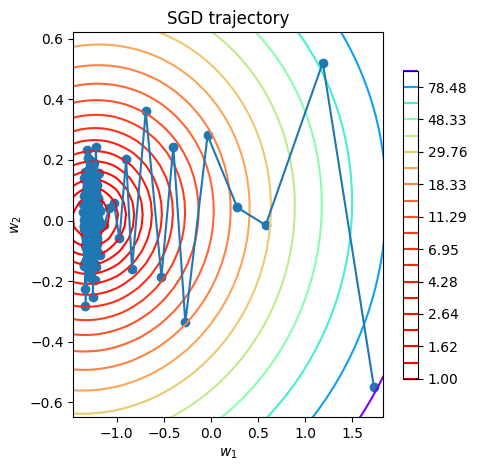

learning rate = 0.0125
batch size = 50
final loss = 1.1059736042927875


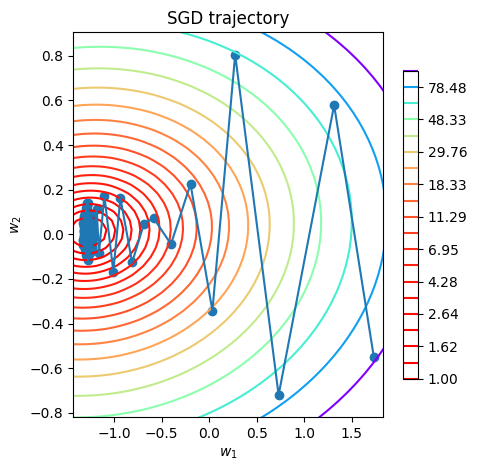

learning rate = 0.0125
batch size = 100
final loss = 0.9745496199615968


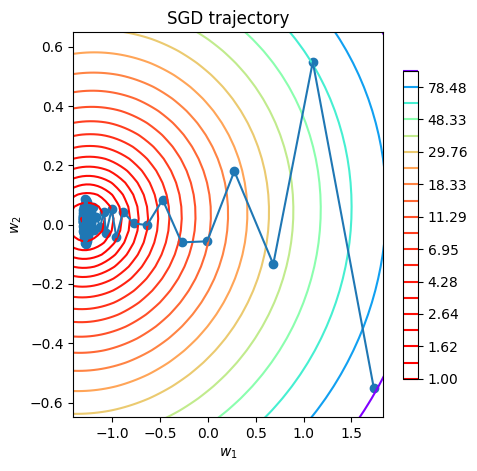

learning rate = 0.0125
batch size = 200
final loss = 0.9699578083062962


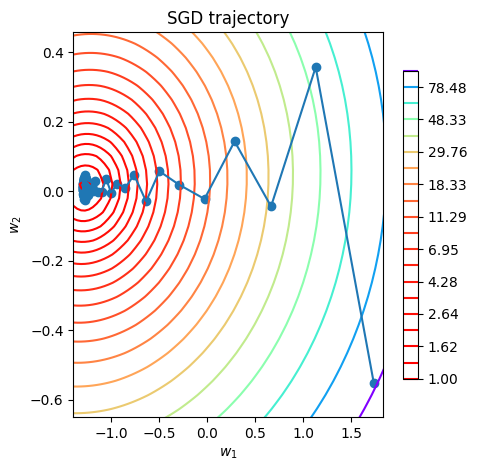

learning rate = 0.0125
batch size = 300
final loss = 0.9667831175818125


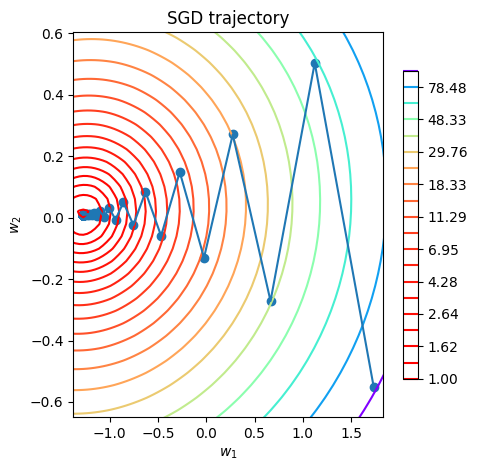

learning rate = 0.01
batch size = 1
final loss = 3.939490906617178


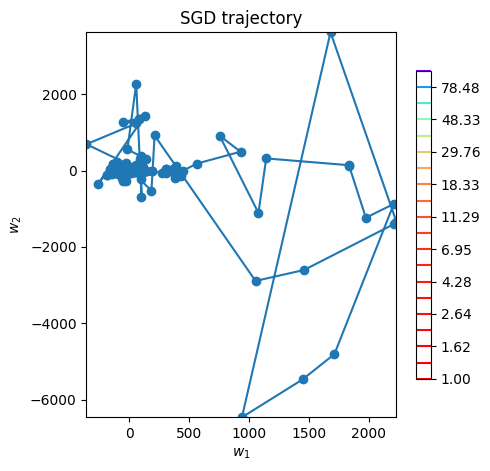

learning rate = 0.01
batch size = 2
final loss = 1.4724727769057953


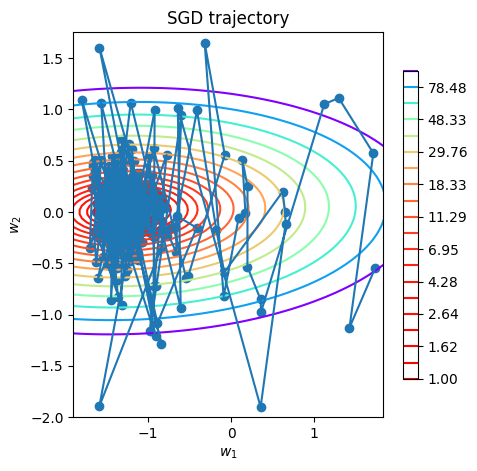

learning rate = 0.01
batch size = 5
final loss = 1.0187498615714135


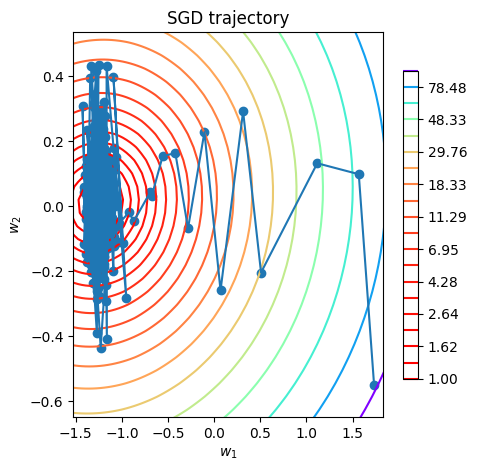

learning rate = 0.01
batch size = 10
final loss = 1.0240598447598006


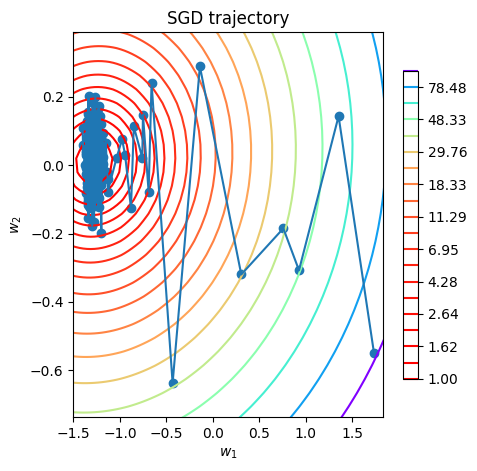

learning rate = 0.01
batch size = 20
final loss = 1.0573034564773012


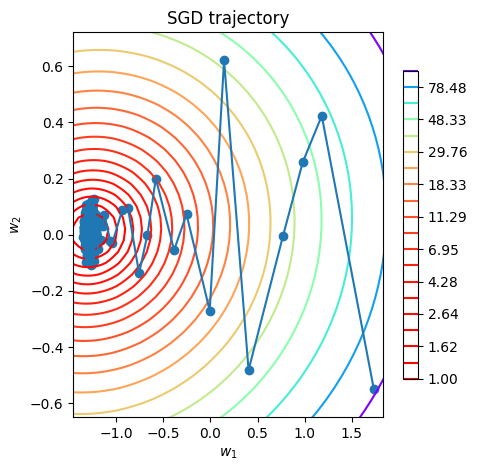

learning rate = 0.01
batch size = 50
final loss = 0.9699955728497535


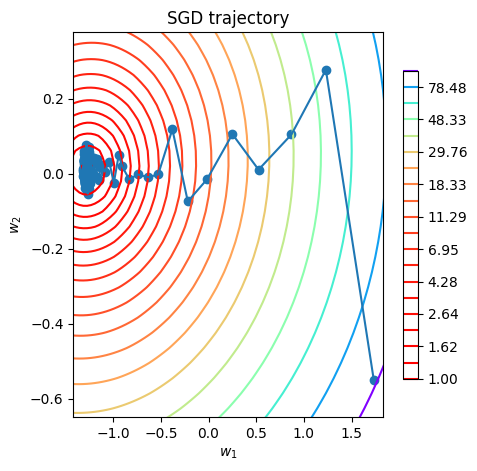

learning rate = 0.01
batch size = 100
final loss = 0.9906594969814769


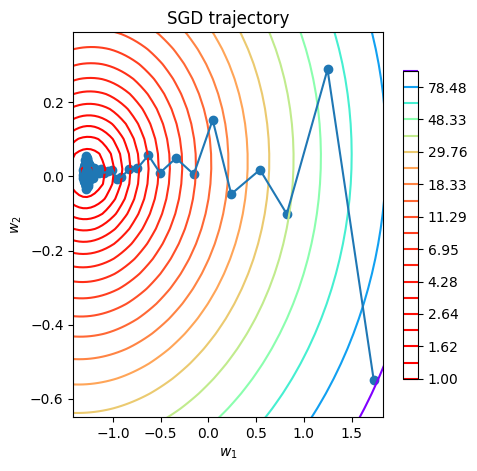

learning rate = 0.01
batch size = 200
final loss = 0.9687672196168673


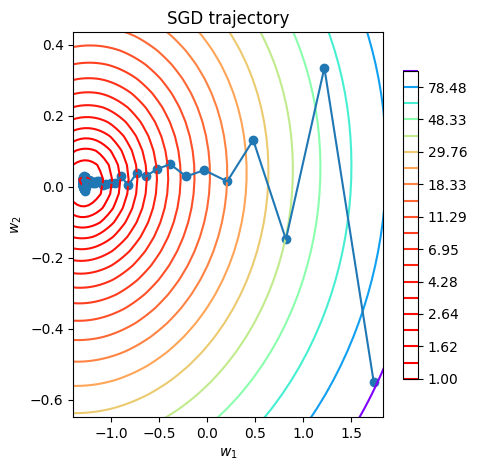

learning rate = 0.01
batch size = 300
final loss = 0.9667831175818125


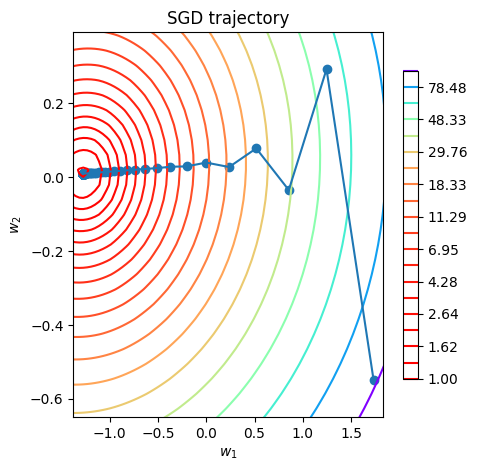

learning rate = 0.001
batch size = 1
final loss = 0.9752835471006503


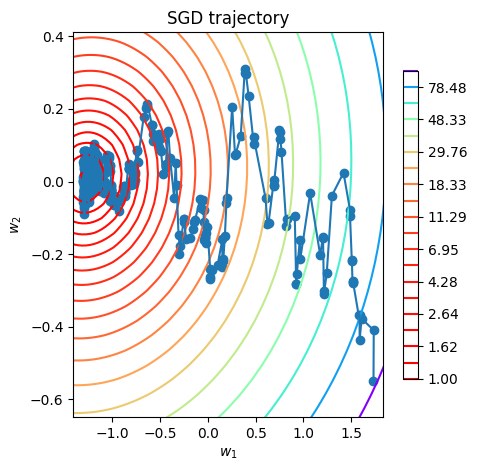

learning rate = 0.001
batch size = 2
final loss = 0.9764773890288712


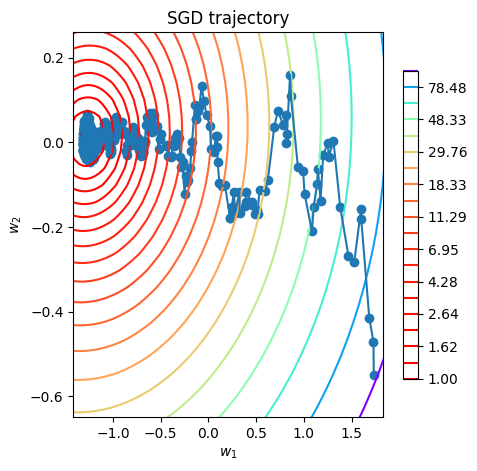

learning rate = 0.001
batch size = 5
final loss = 0.9744580625906618


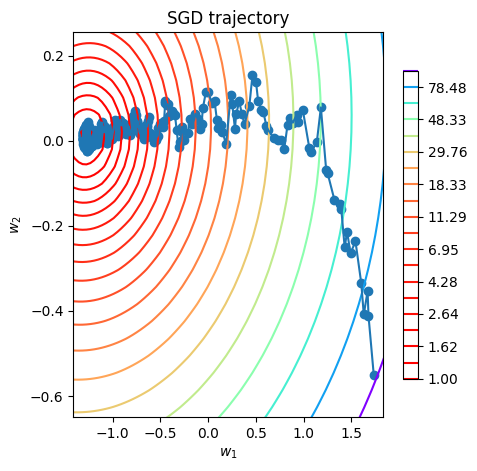

learning rate = 0.001
batch size = 10
final loss = 0.9672351630981931


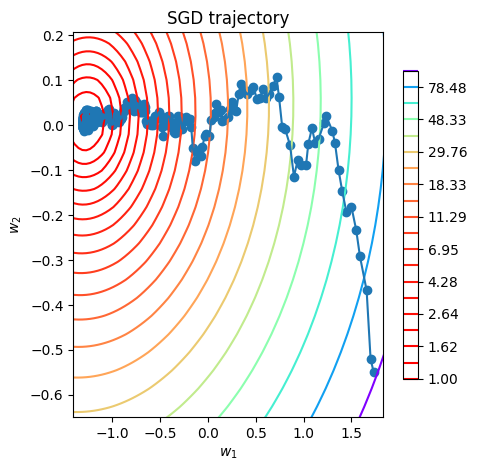

learning rate = 0.001
batch size = 20
final loss = 0.9684909042002806


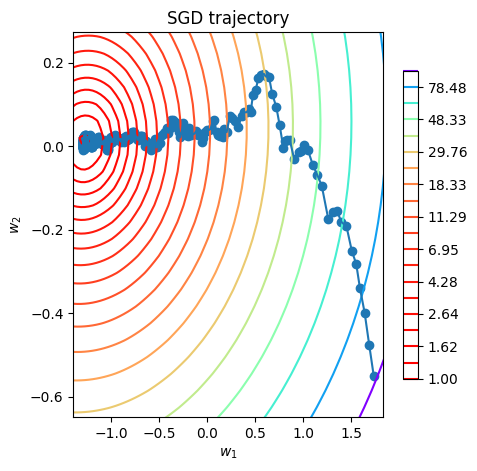

learning rate = 0.001
batch size = 50
final loss = 0.9669826104339819


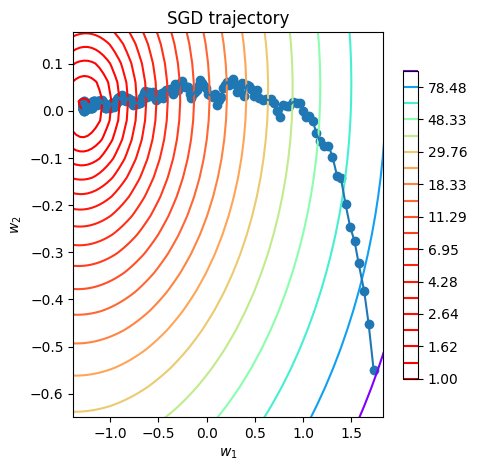

learning rate = 0.001
batch size = 100
final loss = 0.9668936430469754


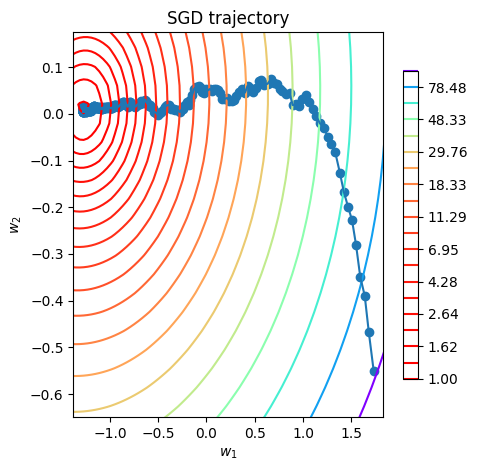

learning rate = 0.001
batch size = 200
final loss = 0.9668311438827463


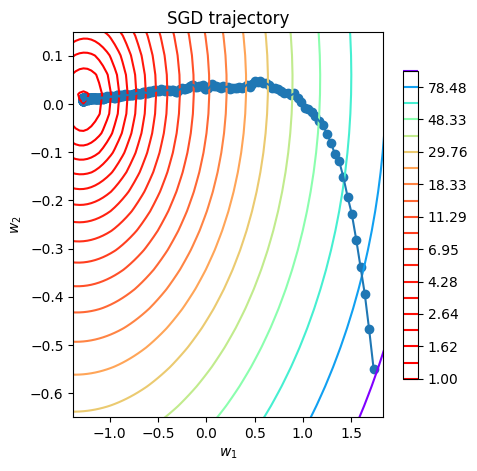

learning rate = 0.001
batch size = 300
final loss = 0.9667831175830535


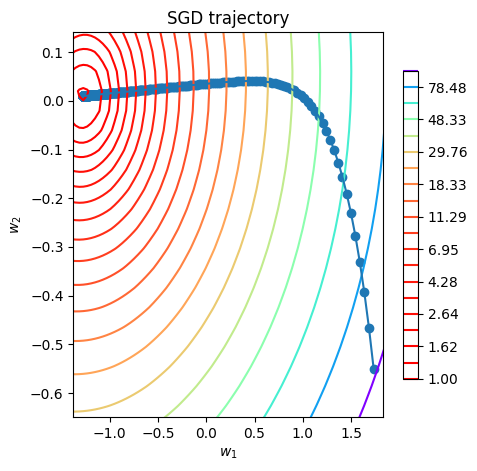

learning rate = 0.0001
batch size = 1
final loss = 4.462772007216605


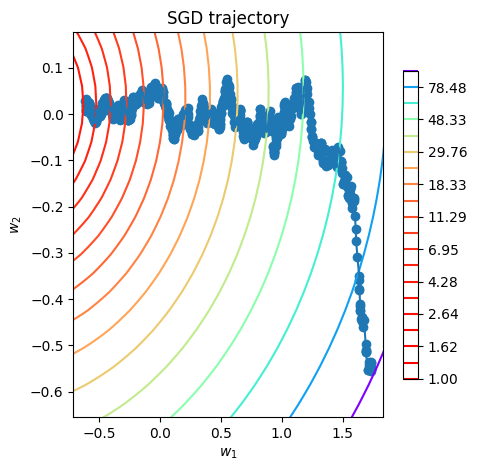

learning rate = 0.0001
batch size = 2
final loss = 3.896658751445605


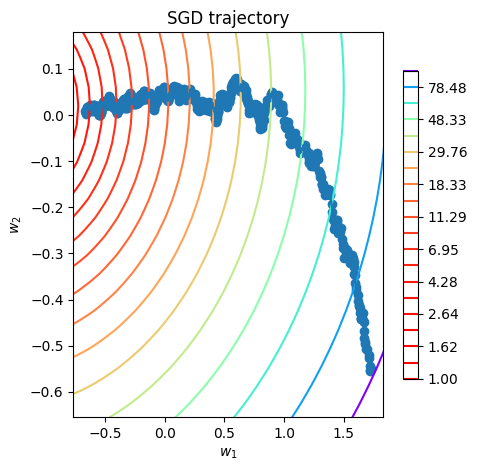

learning rate = 0.0001
batch size = 5
final loss = 4.040343743112697


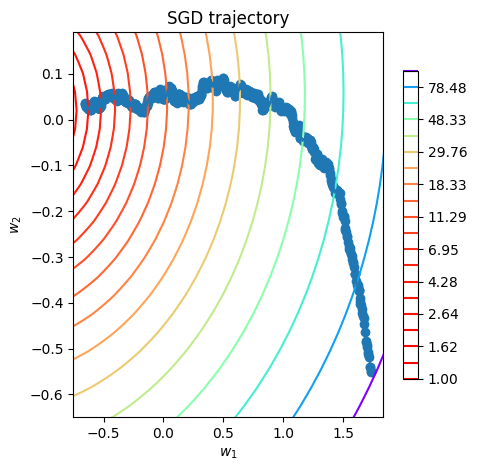

learning rate = 0.0001
batch size = 10
final loss = 4.0770881316943415


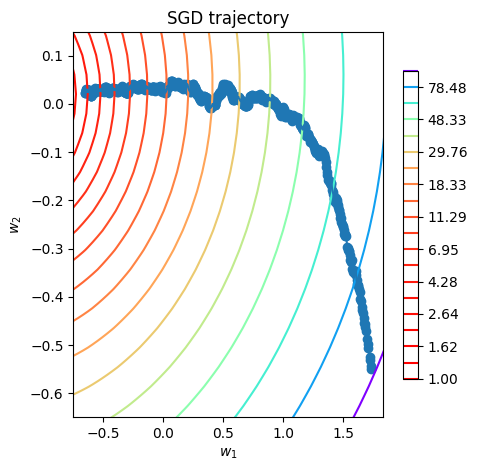

learning rate = 0.0001
batch size = 20
final loss = 3.962862912750154


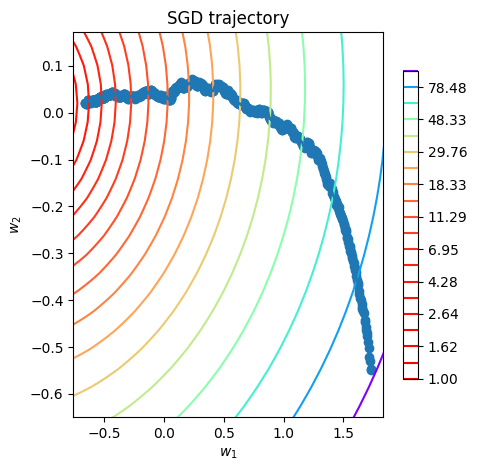

learning rate = 0.0001
batch size = 50
final loss = 4.000446291828291


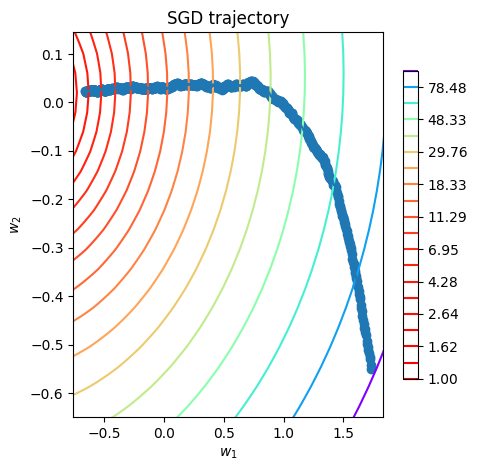

learning rate = 0.0001
batch size = 100
final loss = 4.007424901020124


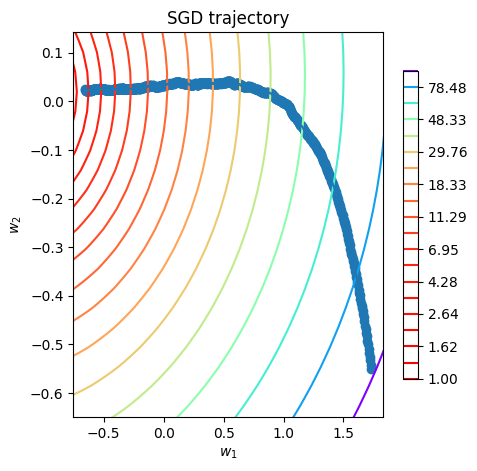

learning rate = 0.0001
batch size = 200
final loss = 3.9961648908853817


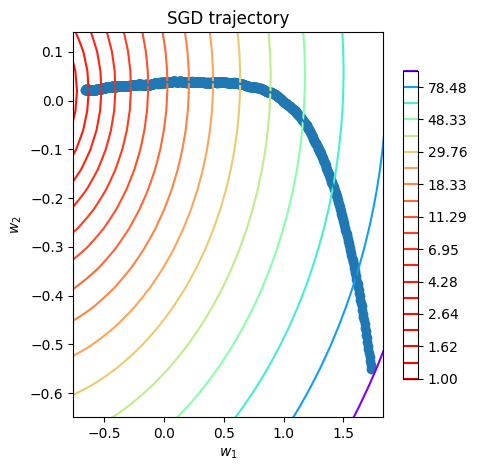

learning rate = 0.0001
batch size = 300
final loss = 4.006414017927979


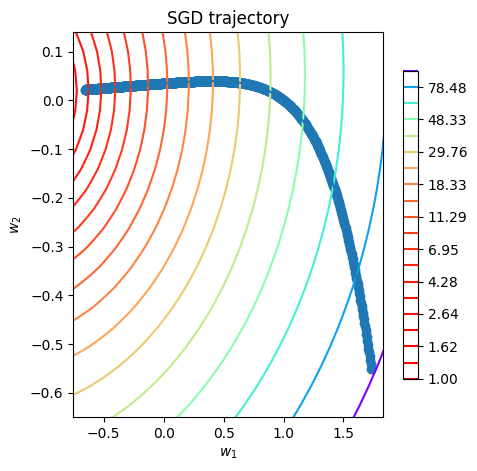

In [11]:
np.random.seed(76843576)

n_features = 2
n_objects = 300
w_true = np.random.normal(size=(n_features,))
X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))
loss = MSELoss()

lr_values = [0.015, 0.0125, 0.01, 0.001, 0.0001]
batch_size_values = [1, 2, 5, 10, 20, 50, 100, 200, 300]

for lr in lr_values:
    for batch_size in batch_size_values:
        w_list = stochastic_gradient_descent(w_init, X, y, loss, lr, batch_size)

        print(f"learning rate = {lr}")
        print(f"batch size = {batch_size}")
        print(f"final loss = {loss.calc_loss(X, y, w_list[-1])}")

        plot_gd(w_list, X, y, loss, title="SGD trajectory")

**Вывод:** стохастический градиентный спуск позволяет уменьшить затраты на вычисления за счёт выбора случайной подвыборки при каждом подсчёте градиента, но из-за этого сложнее управлять сходимостью градиентного спуска: нужен сбалансированный выбор _lr_ и _batch_size_.

Параметр learning_rate по-прежнему важен для скорости сходимости алгоритма, а слишком большие _lr_ так же приводят к "взрыву" градиента.

Параметр batch_size настраивает баланс между точностью и скоростью подсчёта градиента на каждой итерации, слишком низкие значения приводят к хаотическому характеру градиентного спуска, а слишком высокие приближают SGD к обычному градиентному спуску, где градиент считается по всей обучающей выборке.

Вы могли заметить, что поведение градиентного спуска, особенно стохастической версии, очень сильно зависит от размера шага.

Как правило, в начале спуска мы хотим делать большие шаги, чтобы поскорее подойти поближе к минимуму, а позже мы уже хотим делать шаги маленькие, чтобы точнее этого минимума достигнуть и не "перепрыгнуть" его.

Чтобы достичь такого поведения мы можем постепенно уменьшать длину шага с увеличением номера итерации. Сделать это можно, например, вычисляя на каждой итерации длину шага по следующей формуле:

$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$

где $\eta_t$ — длина шага на итерации $t$, $\lambda$ — начальная длина шага (параметр `lr` у нас), $s_0$ и $p$ — настраиваемые параметры.

**Задание 1.6 (5/8 балла):** Реализуйте функцию `stochastic_gradient_descent` на этот раз с затухающим шагом по формуле выше. Параметр $s_0$ возьмите равным 1. Параметр $p$ возьмите из нового аргумента функции `p`.

In [12]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    p: float,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) - начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) - матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) - вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float - параметр величины шага, на который нужно домножать градиент
    :param batch_size: int - размер подвыборки, которую нужно семплировать на каждом шаге
    :param p: float - значение степени в формуле затухания длины шага
    :param n_iterations: int - сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) - история весов на каждом шаге
    """

    weights = [w_init.copy()]
    s_0 = 1

    for i in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        batch = X[batch_indices]
        grad = loss.calc_grad(batch, y[batch_indices], weights[-1])
        learning_rate = lr * np.pow(s_0 / (s_0 + i), p)
        weights.append(weights[-1] - learning_rate * grad)

    return weights

**Задание 1.7 (5/8 балла):** При помощи новой функции `stochastic_gradient_descent` и функции `plot_gd` нарисуйте траекторию градиентного спуска для разных значений параметра `p`. Используйте не менее четырёх разных значений для `p`. Хорошими могут быть значения, лежащие в промежутке от 0.1 до 1.
Параметр `lr` возьмите равным 0.01, а параметр `batch_size` равным 10.

Сделайте и опишите свои выводы о том, как параметр `p` влияет на поведение стохастического градиентного спуска. Что происходит при маленьком или большом значении p?

p = 0.1


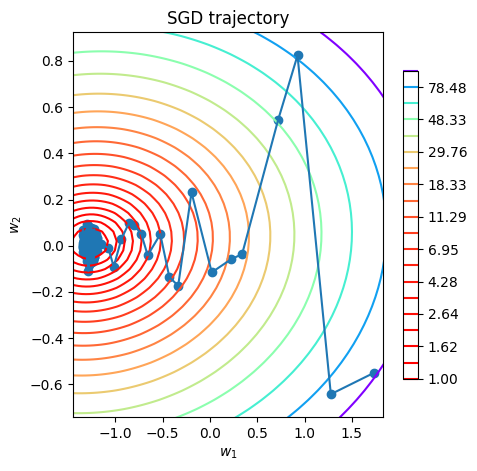

p = 0.3


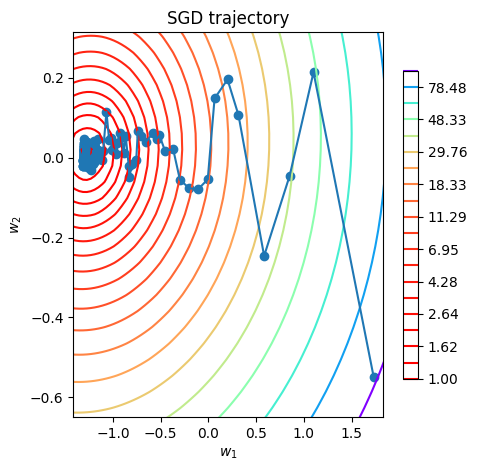

p = 0.5


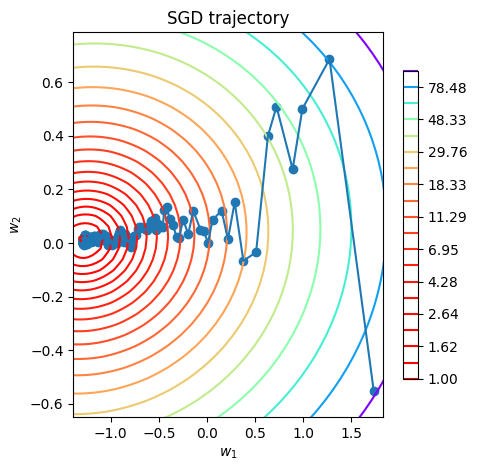

p = 0.7


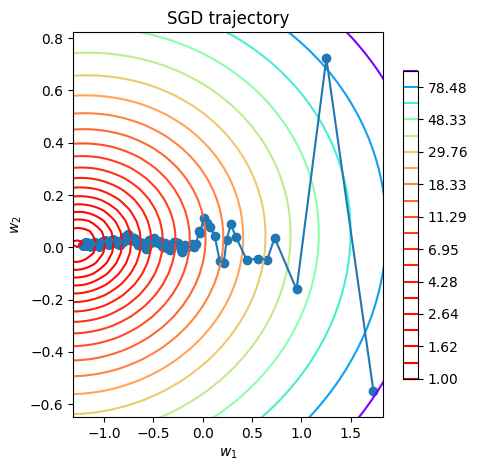

p = 0.9


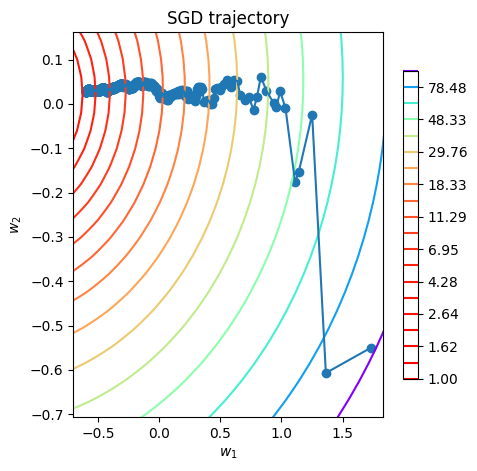

p = 1.0


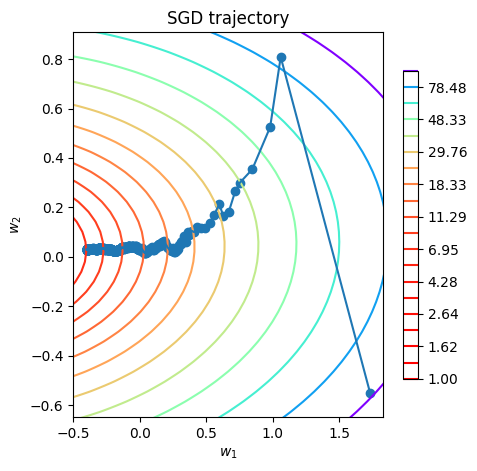

In [13]:
np.random.seed(76843576)

n_features = 2
n_objects = 300
w_true = np.random.normal(size=(n_features,))
X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))
loss = MSELoss()

p_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]

for p in p_values:
    print(f"p = {p}")

    w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.01, 10, p)
    plot_gd(w_list, X, y, loss, title="SGD trajectory")

**Вывод:** параметр _p_ в SGD влияет на скорость уменьшения learning_rate и (косвенно) на скорость сходимости самого градиентного спуска.

Если устанавливать значения _p_ слишком низкими, то на каждой итерации _lr_ будет меняться достаточно слабо и процесс будет в целом аналогичен обычному SGD.

Тем не менее, слишком высокие значения _p_ будут очень быстро приближать _lr_ к нулю, тем самым скорость сходимости градиентного спуска будет сильно ниже, поэтому придётся выполнить больше итераций для приближения к истинной точке минимума функции потерь.

Применительно к стохастическому градиентному спуску, параметр _p_ также можно рассматривать как некоторую компенсацию неточного подсчёта градиента из-за небольшого batch_size: большие значения _p_ способствуют уменьшению хаотичности траектории спуска без увеличения _batch_size_.

**Задание 1.8 (5/8 балла):** Сравните сходимость обычного градиентного спуска и стохастичекой версии:
Нарисуйте график зависимости значения лосса (его можно посчитать при помощи метода `calc_loss`, используя $x$ и $y$ из датасета и $w$ с соответствующей итерации) от номера итерации для траекторий, полученных при помощи обычного и стохастического градиентного спуска с одинаковыми параметрами. Параметр `batch_size` возьмите равным 10.

Видно ли на данном графике преимущество SGD? Почему?

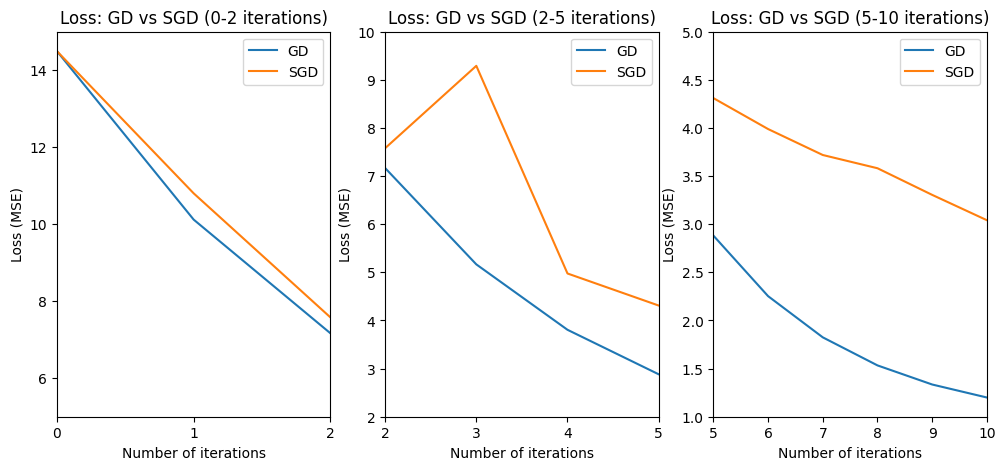

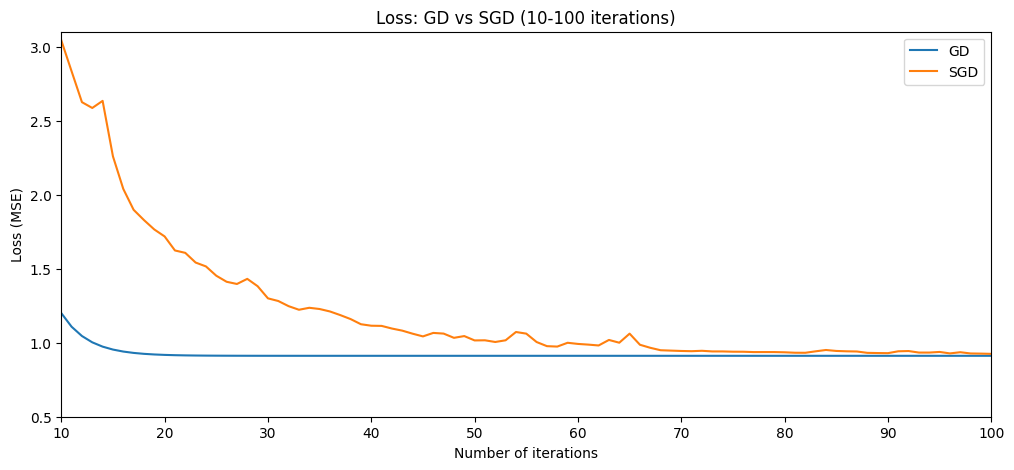

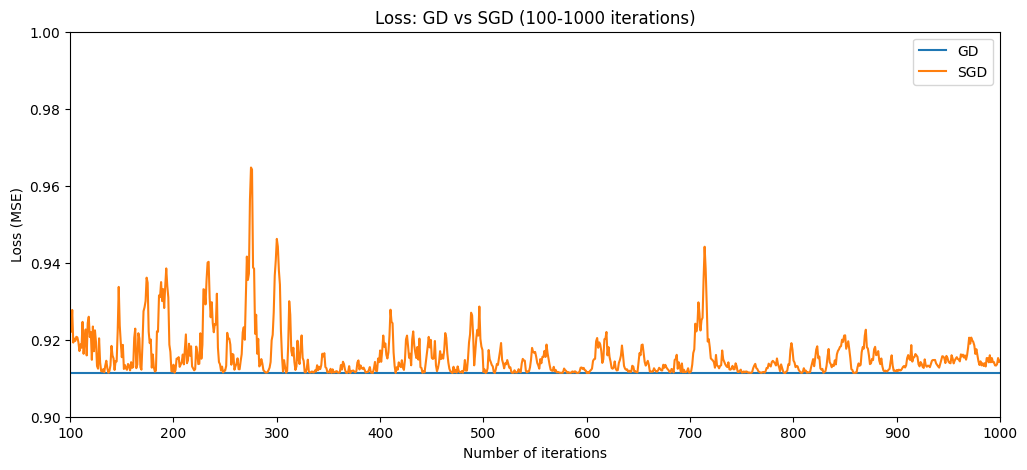

In [14]:
np.random.seed(65473467)

n_features = 2
n_objects = 300
w_true = np.random.normal(size=(n_features,))
X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-1, 1, (n_features))
loss = MSELoss()

gd_path = gradient_descent(w_init, X, y, loss, 0.01, 1000)
sgd_path = stochastic_gradient_descent(w_init, X, y, loss, 0.01, 10, 0.5, 1000)

gd_loss = list(map(lambda w: loss.calc_loss(X, y, w), gd_path))
sgd_loss = list(map(lambda w: loss.calc_loss(X, y, w), sgd_path))

plt.figure(figsize=(12, 5))

ax = plt.subplot(1, 3, 1)
ax.plot(gd_loss, label='GD') 
ax.plot(sgd_loss, label='SGD')
ax.set_xlim(0, 2)
ax.set_ylim(5, 15)
ax.legend()
ax.set_title("Loss: GD vs SGD (0-2 iterations)")
ax.set_xlabel("Number of iterations")
ax.set_ylabel("Loss (MSE)")
ax.set_xticks([0, 1, 2])

ax = plt.subplot(1, 3, 2)
ax.plot(gd_loss, label='GD') 
ax.plot(sgd_loss, label='SGD')
ax.set_xlim(2, 5)
ax.set_ylim(2, 10)
ax.legend()
ax.set_title("Loss: GD vs SGD (2-5 iterations)")
ax.set_xlabel("Number of iterations")
ax.set_ylabel("Loss (MSE)")
ax.set_xticks([2, 3, 4, 5])

ax = plt.subplot(1, 3, 3)
ax.plot(gd_loss, label='GD') 
ax.plot(sgd_loss, label='SGD')
ax.set_xlim(5, 10)
ax.set_ylim(1, 5)
ax.legend()
ax.set_title("Loss: GD vs SGD (5-10 iterations)")
ax.set_xlabel("Number of iterations")
ax.set_ylabel("Loss (MSE)")

plt.show();

plt.figure(figsize=(12, 5))
plt.plot(gd_loss, label='GD') 
plt.plot(sgd_loss, label='SGD')
plt.xlim(10, 100)
plt.ylim(0.5, 3.1)
plt.legend()
plt.title("Loss: GD vs SGD (10-100 iterations)")
plt.xlabel("Number of iterations")
plt.ylabel("Loss (MSE)")
plt.show();

plt.figure(figsize=(12, 5))
plt.plot(gd_loss, label='GD') 
plt.plot(sgd_loss, label='SGD')
plt.xlim(100, 1000)
plt.ylim(0.9, 1)
plt.legend()
plt.title("Loss: GD vs SGD (100-1000 iterations)")
plt.xlabel("Number of iterations")
plt.ylabel("Loss (MSE)")
plt.show();

Исходя из графика падения лосса с количеством итераций, видно, что при небольшом batch_size (10) скорость сходимости стохастического градиентного спуска почти не уступает обычному градиентному спуску. Однако после приближения к точке минимума функции потерь заметны хаотические выбросы в лоссе, поскольку обычный градиентный спуск просто ходит взад-вперёд вокруг точки минимума (градиент просто перепрыгивает оптимум, достигнут предел полезности learning_rate), а в SGD каждый раз градиент считается всего по 10 объектам из выборки, что явно не соответствует правильному определению направления к глобальному минимуму лосса и приводит к случайным повышениям лосса.

## Часть 2. Линейная регрессия (5 баллов)

Теперь давайте напишем наш класс для линейной регрессии. Он будет использовать интерфейс, знакомый нам из библиотеки `sklearn`.

В методе `fit` мы будем подбирать веса `w` при помощи градиентного спуска нашим методом `gradient_descent`.

В методе `predict` мы будем применять нашу регрессию к датасету.

**Задание 2.1 (5/8 балла):** Допишите код в методах `fit` и `predict` класса `LinearRegression`.

В методе `fit` вам нужно как-то инициализировать веса `w`, применить `gradient_descent` и сохранить последнюю `w` из траектории.

В методе `predict` вам нужно применить линейную регрессию и вернуть вектор ответов.

Обратите внимание, что объект лосса передаётся в момент инициализации и хранится в `self.loss`. Его нужно использовать в `fit` для `gradient_descent`.

In [15]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        X = np.asarray(X)
        y = np.asarray(y)
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        self.w = gradient_descent(
            w_init=np.zeros(X.shape[1]),
            X=X,
            y=y,
            loss=self.loss,
            lr=self.lr,
        )[-1]

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        X = np.asarray(X)
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        return X @ self.w

Теперь у нас есть наш класс линейной регрессии. Более того, мы можем управлять тем, какую функцию потерь мы оптимизируем, просто передавая разные классы в параметр `loss` при инициализации.

Пока у нас нет никаких классов кроме `MSELoss`, но скоро они появятся.

Для `MSELoss` мы бы создавали наш объект линейной регрессии, например, так:

In [16]:
linear_regression = LinearRegression(MSELoss())

Применим нашу регрессию на реальном датасете. Загрузим датасет с машинами, который был у вас на семинарах:

In [17]:
X_raw = pd.read_csv(
    "cars_data.csv",
    header=None,
    na_values=["?"],
    skiprows=1,
    index_col=0
)
X_raw = X_raw[~X_raw[26].isna()].reset_index(drop=True)
X_raw.head()

1      2            3    4    5     6            7    8      9     10  ...  \
0   3    NaN  alfa-romero  gas  std   two  convertible  rwd  front  88.6  ...   
1   3    NaN  alfa-romero  gas  std   two  convertible  rwd  front  88.6  ...   
2   1    NaN  alfa-romero  gas  std   two    hatchback  rwd  front  94.5  ...   
3   2  164.0         audi  gas  std  four        sedan  fwd  front  99.8  ...   
4   2  164.0         audi  gas  std  four        sedan  4wd  front  99.4  ...   

    17    18    19    20    21     22      23  24  25       26  
0  130  mpfi  3.47  2.68   9.0  111.0  5000.0  21  27  13495.0  
1  130  mpfi  3.47  2.68   9.0  111.0  5000.0  21  27  16500.0  
2  152  mpfi  2.68  3.47   9.0  154.0  5000.0  19  26  16500.0  
3  109  mpfi  3.19  3.40  10.0  102.0  5500.0  24  30  13950.0  
4  136  mpfi  3.19  3.40   8.0  115.0  5500.0  18  22  17450.0  

[5 rows x 26 columns]

This data set consists of three types of entities:

(a) the specification of an auto in terms of various characteristics,

(b) its assigned insurance risk rating,

(c) its normalized losses in use as compared to other cars.

The second rating corresponds to the degree to which the auto is more risky than its price indicates. Cars are initially assigned a risk factor symbol associated with its price. Then, if it is more risky (or less), this symbol is adjusted by moving it up (or down) the scale. Actuarians call this process "symboling". A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe.

The third factor is the relative average loss payment per insured vehicle year. This value is normalized for all autos within a particular size classification (two-door small, station wagons, sports/speciality, etc…), and represents the average loss per car per year.

Сolumns

1. symboling  (rating corresponds to the degree to which the auto is more risky than its price indicates. Cars are initially assigned a risk factor symbol associated with its price. Then, if it is more risky (or less), this symbol is adjusted by moving it up (or down) the scale. Actuarians call this process "symboling")
2. normalized-losses
3. make
4. fuel-type
5. aspiration
6. num-of-doors
7. body-style
8. drive-wheels
9.  engine-location
10. wheel-base
11. length
12. width
13. height
14. curb-weight
15. engine-type
16. num-of-cylinders
17. engine-size
18. fuel-system
19. bore
20. stroke
21. compression-ratio
22. horsepower
23. peak-rpm
24. city-mpg
25. highway-mpg
26. price

In [18]:
y = X_raw[26]
X_raw = X_raw.drop(26, axis=1)

**Задание 2.2 (5/8 балла):** Как обычно обработайте датасет всеми нужными методами, чтобы на нём можно было обучать линейную регрессию:

* Разделите датасет на обучающую и тестовую выборку
* Заполните пропуски
* Нормализуйте числовые признаки
* Закодируйте категориальные переменные

In [19]:
X_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       201 non-null    int64  
 1   2       164 non-null    float64
 2   3       201 non-null    object 
 3   4       201 non-null    object 
 4   5       201 non-null    object 
 5   6       199 non-null    object 
 6   7       201 non-null    object 
 7   8       201 non-null    object 
 8   9       201 non-null    object 
 9   10      201 non-null    float64
 10  11      201 non-null    float64
 11  12      201 non-null    float64
 12  13      201 non-null    float64
 13  14      201 non-null    int64  
 14  15      201 non-null    object 
 15  16      201 non-null    object 
 16  17      201 non-null    int64  
 17  18      201 non-null    object 
 18  19      197 non-null    float64
 19  20      197 non-null    float64
 20  21      201 non-null    float64
 21  22      199 non-null    float64
 22  23

In [20]:
X_raw[X_raw[2].isna() | X_raw[6].isna() | X_raw[19].isna() | X_raw[20].isna() | X_raw[22].isna() | X_raw[23].isna()][[2, 6, 19, 20, 22, 23]]

2     6     19    20     22      23
0      NaN   two  3.47  2.68  111.0  5000.0
1      NaN   two  3.47  2.68  111.0  5000.0
2      NaN   two  2.68  3.47  154.0  5000.0
5      NaN   two  3.19  3.40  110.0  5500.0
7      NaN  four  3.19  3.40  110.0  5500.0
13     NaN  four  3.31  3.19  121.0  4250.0
14     NaN  four  3.62  3.39  182.0  5400.0
15     NaN   two  3.62  3.39  182.0  5400.0
16     NaN  four  3.62  3.39  182.0  5400.0
26   148.0   NaN  3.03  3.39  102.0  5500.0
42     NaN  four  3.31  3.23   78.0  4800.0
43     NaN   two  3.43  3.23   90.0  5000.0
45     NaN  four  3.63  4.17  176.0  4750.0
46     NaN   two  3.54  2.76  262.0  5000.0
52   150.0   two   NaN   NaN  101.0  6000.0
53   150.0   two   NaN   NaN  101.0  6000.0
54   150.0   two   NaN   NaN  101.0  6000.0
55   150.0   two   NaN   NaN  135.0  6000.0
60     NaN   NaN  3.39  3.39   64.0  4650.0
63     NaN  four  3.43  3.64   72.0  4200.0
68     NaN  four  3.46  3.10  155.0  4750.0
70     NaN  four  3.80  3.35  184.0  4500.0
71     NaN   two  3.80  3.35  184.0  4500.0
72     NaN   two  3.78  3.12  175.0  5000.0
79     NaN   two  3.58  3.86  145.0  5000.0
80     NaN   two  3.59  3.86  145.0  5000.0
81     NaN   two  3.59  3.86  145.0  5000.0
106    NaN  four  3.46  3.19   97.0  5000.0
107    NaN  four  3.70  3.52   95.0  4150.0
110    NaN  four  3.46  2.19   95.0  5000.0
111    NaN  four  3.70  3.52   95.0  4150.0
121    NaN   two  3.59  3.86  145.0  5000.0
123    NaN   two  3.74  2.90  207.0  5900.0
124    NaN   two  3.74  2.90  207.0  5900.0
125    NaN   two  3.74  2.90  207.0  5900.0
126    NaN  four  3.46  3.90    NaN     NaN
127    NaN   two  3.46  3.90    NaN     NaN
177    NaN  four  3.27  3.35  156.0  5200.0
185    NaN   two  3.19  3.40   90.0  5500.0
187    NaN  four  3.19  3.40  110.0  5500.0
188    NaN  four  3.01  3.40   68.0  4500.0
189    NaN  four  3.19  3.40   88.0  5500.0

In [21]:
X_raw[2] = X_raw[2].fillna(X_raw[2].median())
X_raw[6] = X_raw[6].fillna(X_raw[6].mode()[0]) # заполняем самым популярным значением
X_raw[19] = X_raw[19].fillna(X_raw[19].median())
X_raw[20] = X_raw[20].fillna(X_raw[20].median())
X_raw[22] = X_raw[22].fillna(X_raw[22].median())
X_raw[23] = X_raw[23].fillna(X_raw[23].median())

In [22]:
X_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       201 non-null    int64  
 1   2       201 non-null    float64
 2   3       201 non-null    object 
 3   4       201 non-null    object 
 4   5       201 non-null    object 
 5   6       201 non-null    object 
 6   7       201 non-null    object 
 7   8       201 non-null    object 
 8   9       201 non-null    object 
 9   10      201 non-null    float64
 10  11      201 non-null    float64
 11  12      201 non-null    float64
 12  13      201 non-null    float64
 13  14      201 non-null    int64  
 14  15      201 non-null    object 
 15  16      201 non-null    object 
 16  17      201 non-null    int64  
 17  18      201 non-null    object 
 18  19      201 non-null    float64
 19  20      201 non-null    float64
 20  21      201 non-null    float64
 21  22      201 non-null    float64
 22  23

In [23]:
cat_features = X_raw.dtypes[X_raw.dtypes == np.object_].index.tolist()

for feature in cat_features:
    X_raw = pd.concat(
        [X_raw, pd.get_dummies(X_raw[feature], prefix=str(feature), prefix_sep='=', dtype=np.int8)],
        axis=1,
    ).drop(feature, axis=1)

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, random_state=42,
)

In [26]:
non_cat_features = list(set(X_raw.columns.to_list()[:15]) - set(cat_features))

scaler = StandardScaler().fit(X_train[non_cat_features])
X_train[non_cat_features] = scaler.transform(X_train[non_cat_features])
X_test[non_cat_features] = scaler.transform(X_test[non_cat_features])

**Задание 2.3 (5/8 балла):** Обучите написанную вами линейную регрессию на обучающей выборке

In [27]:
linear_regression = linear_regression.fit(X_train, y_train)

**Задание 2.4 (5/8 балла):** Посчитайте ошибку обученной регрессии на обучающей и тестовой выборке при помощи метода `mean_squared_error` из `sklearn.metrics`.

In [28]:
from sklearn.metrics import mean_squared_error

y_train_pred = linear_regression.predict(X_train)
y_test_pred = linear_regression.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"MSE on train: {mse_train:.3f}")
print(f"MSE on test: {mse_test:.3f}")

MSE on train: 1391412.594
MSE on test: 10613683.241


In [29]:
for w_name, w_value in zip(["w_0"] + X_train.columns.to_list(), linear_regression.w):
    print(f"{str(w_name).rjust(15)} -> {w_value:.3f}")

            w_0 -> -158.170
              1 -> -148.293
              2 -> 1151.603
             10 -> -1304.901
             11 -> 1036.835
             12 -> -648.286
             13 -> 3287.182
             14 -> 781.983
             17 -> -476.931
             19 -> -167.113
             20 -> -2481.387
             21 -> -114.868
             22 -> 468.848
             23 -> -459.489
             24 -> 748.887
             25 -> 536.409
  3=alfa-romero -> 4220.835
         3=audi -> 6457.534
          3=bmw -> -2080.222
    3=chevrolet -> -2642.510
        3=dodge -> 695.161
        3=honda -> -3477.341
        3=isuzu -> 4009.382
       3=jaguar -> 83.401
        3=mazda -> 2790.314
3=mercedes-benz -> -1576.551
      3=mercury -> -2099.586
   3=mitsubishi -> -110.730
       3=nissan -> -2246.243
       3=peugot -> -2596.808
     3=plymouth -> 6372.220
      3=porsche -> -1039.068
      3=renault -> 3482.919
         3=saab -> -2985.373
       3=subaru -> -1759.990
       3=toyota

Наша модель переобучилась. Давайте как обычно в такой ситуации добавим к ней L2 регуляризацию. Для этого нам нужно написать новый класс лосса.

Формула функции потерь для MSE с L2 регуляризацией выглядит так:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

Или в матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$

Где $\lambda$ — коэффициент регуляризации.

Градиент выглядит так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

**Задание 2.5 (5/8 балла):** Реализуйте класс `MSEL2Loss`.

Он должен вычислять лосс и градиент по формулам выше.

Подсказка: обратите внимание, что последний элемент вектора `w` — это bias (в классе `LinearRegression` к матрице `X` добавляется колонка из единиц — константный признак). Как мы знаем из лекций и семинаров, bias регуляризовать не нужно. Поэтому не забудьте убрать последний элемент из `w` при подсчёте слагаемого $\lambda||w||^2$ в `calc_loss` и занулить его при подсчёте слагаемого $2 \lambda w$ в `calc_grad`.

In [30]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.0):
        """
        :param coef: коэффициент регуляризации (лямбда в формуле)
        """
        self.coef = coef

    def check_params(
            self,
            X: np.ndarray | pd.DataFrame,
            y: np.ndarray | pd.Series,
            w: np.ndarray | pd.Series) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Функция для проверки параметров методов calc_loss и calc_grad
        :param X: np.ndarray или pd.DataFrame размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray или pd.Series размера (n_objects,) с правильными ответами
        :param w: np.ndarray или pd.Series размера (n_features,) с весами линейной регрессии
        """

        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        if isinstance(y, pd.Series):
            y = y.to_numpy()
        if isinstance(w, pd.Series):
            w = w.to_numpy()

        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray) and isinstance(w, np.ndarray)

        assert len(X.shape) == 2 and len(y.shape) == 1 and len(w.shape) == 1
        assert X.shape[0] == y.shape[0] and X.shape[1] == w.shape[0]

        assert X.dtype == y.dtype == w.dtype

        assert not np.isnan(X).any() and not np.isnan(y).any() and not np.isnan(w).any()
        assert not np.isinf(X).any() and not np.isinf(y).any() and not np.isinf(w).any()

        assert np.unique(X.T[-1]).size == 1

        return X, y, w

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета. Последний признак константный.
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии. Последний вес -- bias.
        :output: число -- значения функции потерь
        """

        X, y, w = self.check_params(X, y, w)

        return np.square(np.linalg.norm(X @ w - y)) / X.shape[0] + self.coef * np.square(np.linalg.norm(w[:-1]))

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """

        X, y, w = self.check_params(X, y, w)

        weights = w.copy()
        weights[-1] = 0

        return X.T @ (X @ w - y) * 2.0 / X.shape[0] + 2 * self.coef * weights

Теперь мы можем использовать лосс с l2 регуляризацией в нашей регрессии, например, так:

In [31]:
linear_regression = LinearRegression(MSEL2Loss(0.1))

**Задание 2.6 (5/8 балла):** Обучите регрессию с лоссом `MSEL2Loss`. Подберите хороший коэффициент регуляризации и добейтесь улучшения результата на тестовой выборке. Сравните результат на обучающей и тестовой выборке с регрессией без регуляризации.

In [32]:
lambdas = np.logspace(-10, 10, 100).astype(float)
best = (0.0, np.inf, )

for lmbd in tqdm(lambdas):
    try:
        with np.errstate(all='ignore'):
            loss = MSEL2Loss(coef=lmbd)
            linreg = LinearRegression(loss=loss)
            linreg.fit(X_train, y_train)
            pred = linreg.predict(X_test)
            loss_test = mean_squared_error(y_test, pred)
            if best[1] > loss_test:
                best = (lmbd, loss_test, )
    except AssertionError or RuntimeWarning:
        pass

best_lambda = best[0]

print(f"best lambda={best_lambda}")

  0%|          | 0/100 [00:00<?, ?it/s]

best lambda=0.001873817422860383


In [33]:
plain_loss = MSELoss()

plain_linreg = LinearRegression(loss=plain_loss)
plain_linreg.fit(X_train, y_train)

y_train_pred = plain_linreg.predict(X_train)
y_test_pred = plain_linreg.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Linear regression without regularization:")
print(f"MSE on train: {mse_train:.3f}")
print(f"MSE on test: {mse_test:.3f}")

l2_loss = MSEL2Loss(coef=best_lambda)

l2_linreg = LinearRegression(loss=l2_loss)
l2_linreg.fit(X_train, y_train)

y_train_pred = l2_linreg.predict(X_train)
y_test_pred = l2_linreg.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Linear regression with L2-regularization:")
print(f"MSE on train: {mse_train:.3f}")
print(f"MSE on test: {mse_test:.3f}")

Linear regression without regularization:
MSE on train: 1391412.594
MSE on test: 10613683.241
Linear regression with L2-regularization:
MSE on train: 1546520.202
MSE on test: 8358507.963


С L2-регуляризацией MSE на тесте действительно немного снизился, однако переобучение никуда не делось. Более того, на трейне MSE даже немного вырос относительно обычной линейной регрессии на MSE без регуляризации.

В нашем датасете могут быть выбросы. На семинаре вам рассказывали, что с выбросами хорошо помогает бороться Huber Loss. Вдали от нуля он работает как Mean Absolute Error и не реагирует на выбросы так сильно, как MSE. Давайте его реализуем и применим в нашей регрессии.

Напомним, что функция потерь Huber Loss'а  выглядит так:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}
$$


А градиент так:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), иначе \\ \end{cases}
$$

**Задание 2.7 (5/8 балла):** Реализуйте класс `HuberLoss`.

Он должен вычислять лосс и градиент по формулам выше.

In [34]:
class HuberLoss(BaseLoss):
    def __init__(self, eps: float) -> None:
        """
        :param eps: параметр huber loss из формулы
        """
        self.eps = eps

    def check_params(
            self,
            X: np.ndarray | pd.DataFrame,
            y: np.ndarray | pd.Series,
            w: np.ndarray | pd.Series) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Функция для проверки параметров методов calc_loss и calc_grad
        :param X: np.ndarray или pd.DataFrame размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray или pd.Series размера (n_objects,) с правильными ответами
        :param w: np.ndarray или pd.Series размера (n_features,) с весами линейной регрессии
        """

        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        if isinstance(y, pd.Series):
            y = y.to_numpy()
        if isinstance(w, pd.Series):
            w = w.to_numpy()

        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray) and isinstance(w, np.ndarray)

        assert len(X.shape) == 2 and len(y.shape) == 1 and len(w.shape) == 1
        assert X.shape[0] == y.shape[0] and X.shape[1] == w.shape[0]

        assert X.dtype == y.dtype == w.dtype

        assert not np.isnan(X).any() and not np.isnan(y).any() and not np.isnan(w).any()
        assert not np.isinf(X).any() and not np.isinf(y).any() and not np.isinf(w).any()

        assert np.unique(X.T[-1]).size == 1

        return X, y, w

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: число -- значения функции потерь
        """

        X, y, w = self.check_params(X, y, w)

        z = X @ w - y

        return np.mean(
            np.where(
                np.abs(z) < self.eps,
                np.square(z) / 2.0,
                (np.abs(z) - self.eps / 2.0) * self.eps,
            )
        ).item()

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """

        X, y, w = self.check_params(X, y, w)

        z = X @ w - y

        return X.T @ np.where(
            np.abs(z) < self.eps,
            z,
            np.sign(z) * self.eps,
        ) / X.shape[0]

**Задание 2.8 (5/8 балла):** Обучите регрессию с лоссом `HuberLoss`. Сравните результат на обучающей и тестовой выборке с регрессией, обученной c `MSELoss`.

In [35]:
eps = np.logspace(-10, 10, 100).astype(float)
best = (0.0, np.inf, )

for epsilon in tqdm(eps):
    try:
        with np.errstate(all='ignore'):
            loss = HuberLoss(eps=epsilon)
            linreg = LinearRegression(loss=loss)
            linreg.fit(X_train, y_train)
            pred = linreg.predict(X_test)
            loss_test = mean_squared_error(y_test, pred)
            if best[1] > loss_test:
                best = (epsilon, loss_test, )
    except AssertionError or RuntimeWarning:
        pass

best_eps = best[0]

print(f"best epsilon={best_eps}")

  0%|          | 0/100 [00:00<?, ?it/s]

best epsilon=83.02175681319736


In [36]:
plain_loss = MSELoss()

plain_linreg = LinearRegression(loss=plain_loss)
plain_linreg.fit(X_train, y_train)

y_train_pred = plain_linreg.predict(X_train)
y_test_pred = plain_linreg.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Linear regression with MSE loss:")
print(f"MSE on train: {mse_train:.3f}")
print(f"MSE on test: {mse_test:.3f}")

huber_loss = HuberLoss(eps=best_eps)

huber_linreg = LinearRegression(loss=huber_loss)
huber_linreg.fit(X_train, y_train)

y_train_pred = huber_linreg.predict(X_train)
y_test_pred = huber_linreg.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Linear regression with Huber loss:")
print(f"MSE on train: {mse_train:.3f}")
print(f"MSE on test: {mse_test:.3f}")

Linear regression with MSE loss:
MSE on train: 1391412.594
MSE on test: 10613683.241
Linear regression with Huber loss:
MSE on train: 2025645.177
MSE on test: 8171039.263


Применение HuberLoss вместо обычного MSE в целом даёт хороший результат на тесте, значит, в датасете действительно присутствуют выбросы, от зависимости от которых частично удалось избавиться засчёт параметра epsilon в HuberLoss. Правда от переобучения избавиться по-прежнему избавиться не удалось, а на трейне лосс даже вырос относительно обычной линейной регрессии с MSE. Зато MSE на тесте получился ниже, чем при использовании L2-регуляризации :)

**Задание 3 (0.08/8 балла)**
Вставьте ваш любимый мем 2025 в ячейку ниже:

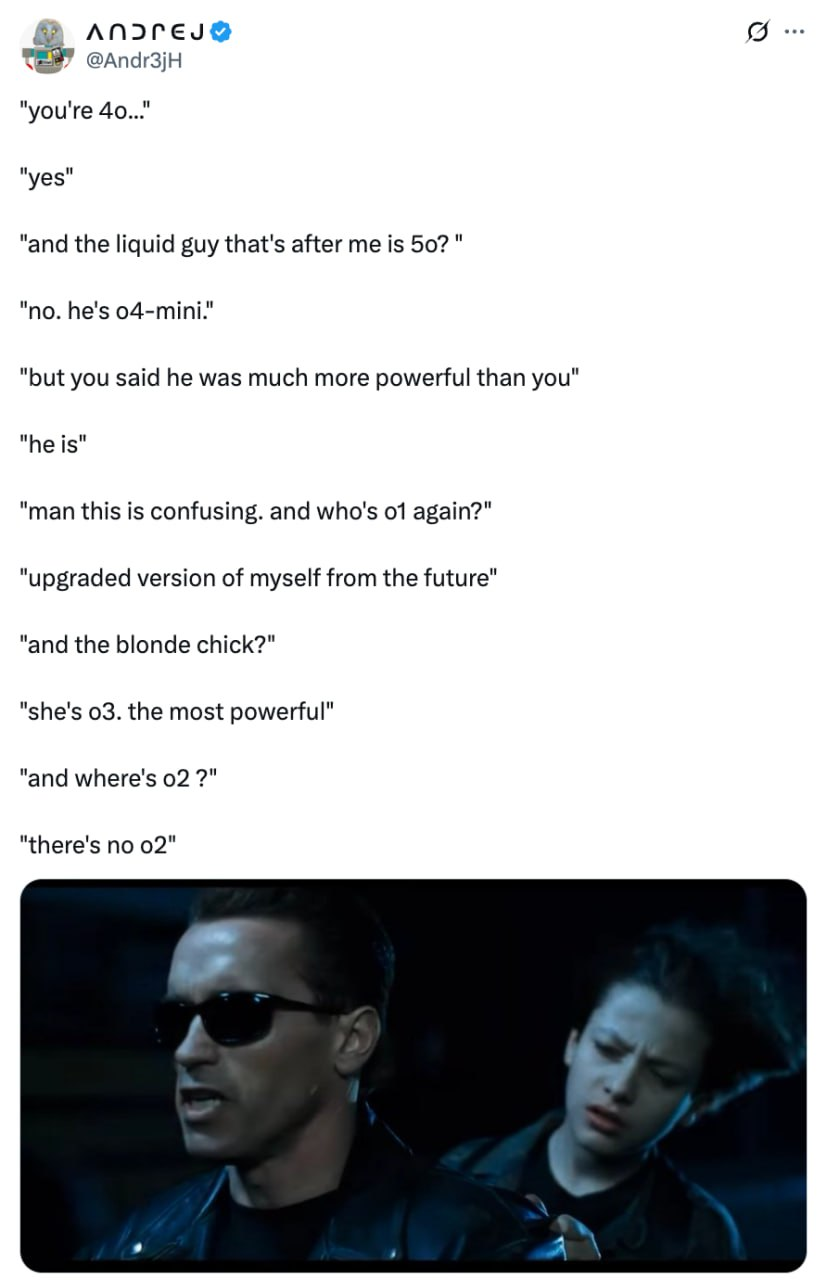

Если бы фильм «Терминатор» снимали по релизам OpenAI:

```
— «Ты — 4o…»
— «Да»
— «А жидкий парень, который за мной гонится — это 5o?»
— «Нет. Это o4-mini.»
— «Но ты же говорил, что он намного мощнее тебя»
— «Так и есть»
— «Чёрт, это всё запутанно. А кто такой o1?»
— «Улучшенная версия меня самого из будущего»
— «А та блондинка?»
— «Она — o3. Самая мощная»
— «А где o2?»
— «o2 не существует»
```

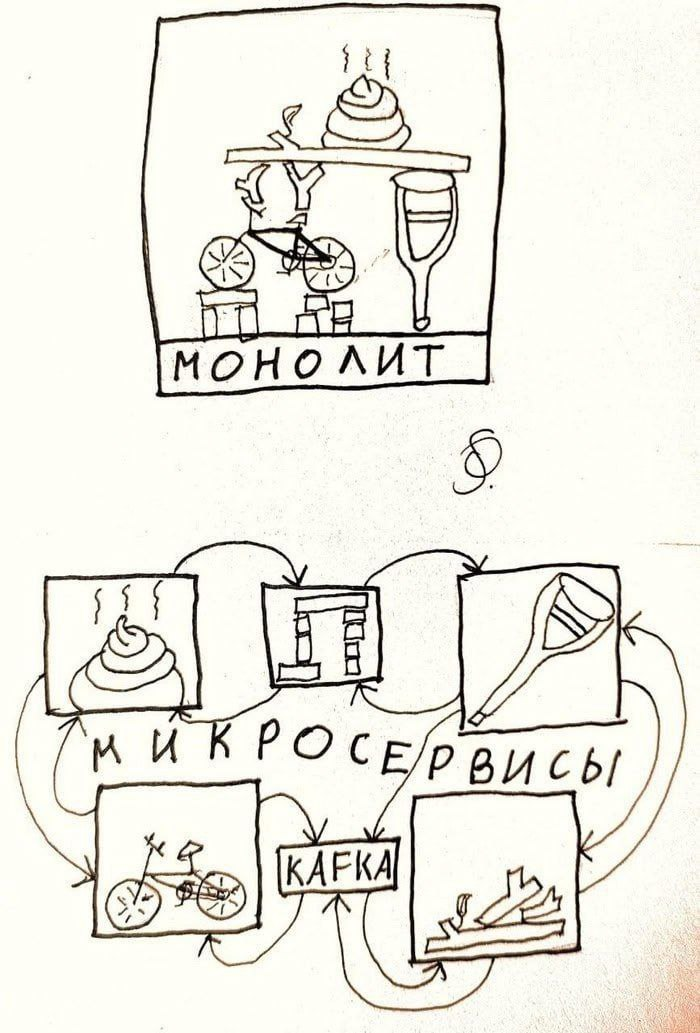

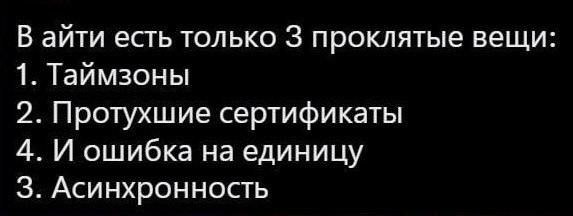

### БОНУС (2 балла)

Градиентный спуск — далеко не единственный метод оптимизации.
Другой очень известный метод называется ["Алгоритм имитации отжига"](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%B8%D0%BC%D0%B8%D1%82%D0%B0%D1%86%D0%B8%D0%B8_%D0%BE%D1%82%D0%B6%D0%B8%D0%B3%D0%B0). Он не так часто используется для оптимизации моделей машинного обучения, но у вас есть уникальная возможность попробовать применить его к нашей любимой линейной регрессии.

**Задание (2 балла)**:
Напишите алгоритм имитации отжига для оптимизации MSE линейной регрессии.

Сравните результат с градиентным спуском по "траектории" и по финальному лоссу.

Подсказка: каждую новую точку (веса регресси в нашем случае) можно семплировать из некоторого случайного распределения с центром в текущей точке. Хорошо подойдут распределения с "тяжёлыми" хвостами, например, распределение Стьюдента с параметром количества степеней свободы в районе 3.
Это может выглядеть, например, так:
```
new_w = old_w + np.random.standard_t(3, size=old_w.shape)
```
С параметром распределения можно поэксперементировать: чем он больше, тем реже новые точки будут очень сильно уходить от старых.

In [37]:
def simulated_annealing(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    alpha: float,
    t_0: float,
    t_min: float = 0.0,
    n_iterations: int = 100000,
    random_seed: int = 42,
) -> List[np.ndarray]:
    """
    Функция алгоритма имитации отжига
    :param w_init: np.ndarray размера (n_features,) - начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) - матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) - вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать лосс при помощи loss.calc_loss(X, y, w)
    :param alpha: float - коэффициент охлаждения (0 < alpha < 1)
    :param t_0: float -- параметр начальной температуры T0
    :param t_min: float -- параметр минимальной температуры T_min
    :param n_iterations: int --сколько итераций делать
    :param random_seed: int -- seed для генератора случайных чисел
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) - история весов на каждом шаге
    """

    old_w = w_init.copy()
    old_loss = loss.calc_loss(X, y, old_w)

    weights = [old_w]
    t = t_0
    i = 0

    np.random.seed(random_seed)

    while t > t_min and i < n_iterations:
        new_w = old_w + np.random.standard_t(3, size=old_w.shape)
        new_loss = loss.calc_loss(X, y, new_w)
        delta = new_loss - old_loss

        if delta <= 0 or np.random.rand() < np.exp(-delta / t):
            old_w, old_loss = new_w, new_loss

        weights.append(old_w)

        t *= alpha
        i += 1

    return weights

In [38]:
np.random.seed(42)

n_features = 2
n_objects = 500
w_true = np.random.normal(size=(n_features,))
X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))
loss = MSELoss()

In [39]:
alpha_values = np.logspace(-20, 0, 100).astype(float)[:-1]
t_0_values = np.logspace(-10, 10, 100).astype(float)
t_min_values = np.logspace(-10, 10, 100).astype(float)

best_loss = np.inf
best_params = (0.0, 0.0, 0.0)

for alpha in tqdm(alpha_values):
    for t_0 in t_0_values:
        for t_min in t_min_values:
            if t_0 < t_min:
                continue

            try:
                with np.errstate(all='ignore'):
                    w_list = simulated_annealing(w_init, X, y, loss, alpha, t_0, t_min)
                    pred = X.dot(w_list[-1])
                    mse = mean_squared_error(pred, y)

                    if mse < best_loss:
                        best_loss = mse
                        best_params = (alpha, t_0, t_min)
            except AssertionError or RuntimeWarning:
                pass

  0%|          | 0/99 [00:00<?, ?it/s]

In [40]:
best_alpha, best_t_0, best_t_min = best_params
print(f"best alpha: {best_alpha}, best t_0: {best_t_0}, best t_min: {best_t_min}")

best alpha: 0.6280291441834273, best t_0: 385352859.37105197, best t_min: 1e-10


In [41]:
lr_values = np.logspace(-10, 10, 100).astype(float)
best_lr = 0.0
best_loss = np.inf

for lr in lr_values:
    try:
        with np.errstate(all='ignore'):
            w_list = gradient_descent(w_init, X, y, loss, lr)
            pred = X.dot(w_list[-1])
            mse = mean_squared_error(pred, y)

            if mse < best_loss:
                best_loss = mse
                best_lr = lr
    except AssertionError or RuntimeWarning:
        pass

In [42]:
print(f"best learning rate: {best_lr}")

best learning rate: 0.012045035402587835


In [43]:
w_list_gd = gradient_descent(w_init, X, y, loss, best_lr)
w_list_sa = simulated_annealing(w_init, X, y, loss, best_alpha, best_t_0, best_t_min)

print(f"Gradient descent loss: {mean_squared_error(y, X @ w_list_gd[-1]):.5f}")
print(f"Simulated annealing loss: {mean_squared_error(y, X @ w_list_sa[-1]):.5f}")

print(f"Gradient descent made {len(w_list_gd) - 1} iterations")
print(f"Simulated annealing made {len(w_list_sa) - 1} iterations")

Gradient descent loss: 0.97068
Simulated annealing loss: 0.98780
Gradient descent made 100000 iterations
Simulated annealing made 93 iterations


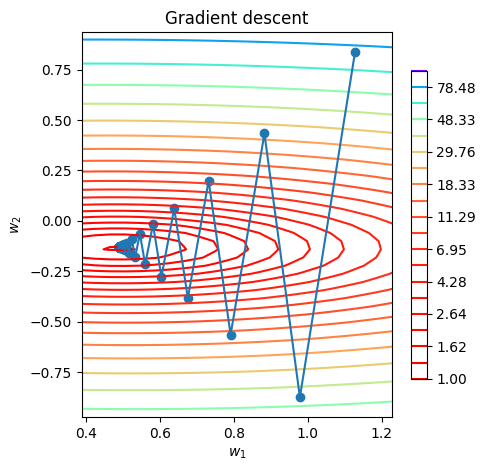

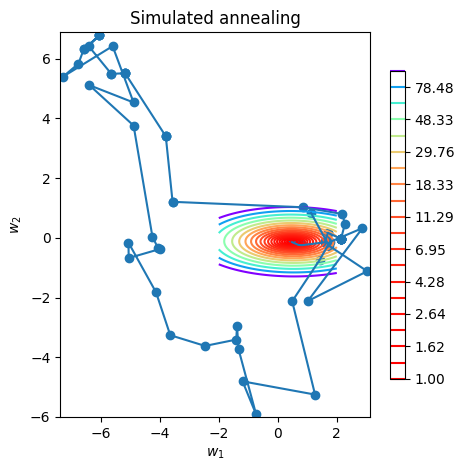

In [44]:
plot_gd(w_list_gd, X, y, loss, title="Gradient descent")
plot_gd(w_list_sa, X, y, loss, title="Simulated annealing")

In [45]:
gd_loss = list(map(lambda w: loss.calc_loss(X, y, w), w_list_gd))
sa_loss = list(map(lambda w: loss.calc_loss(X, y, w), w_list_sa))

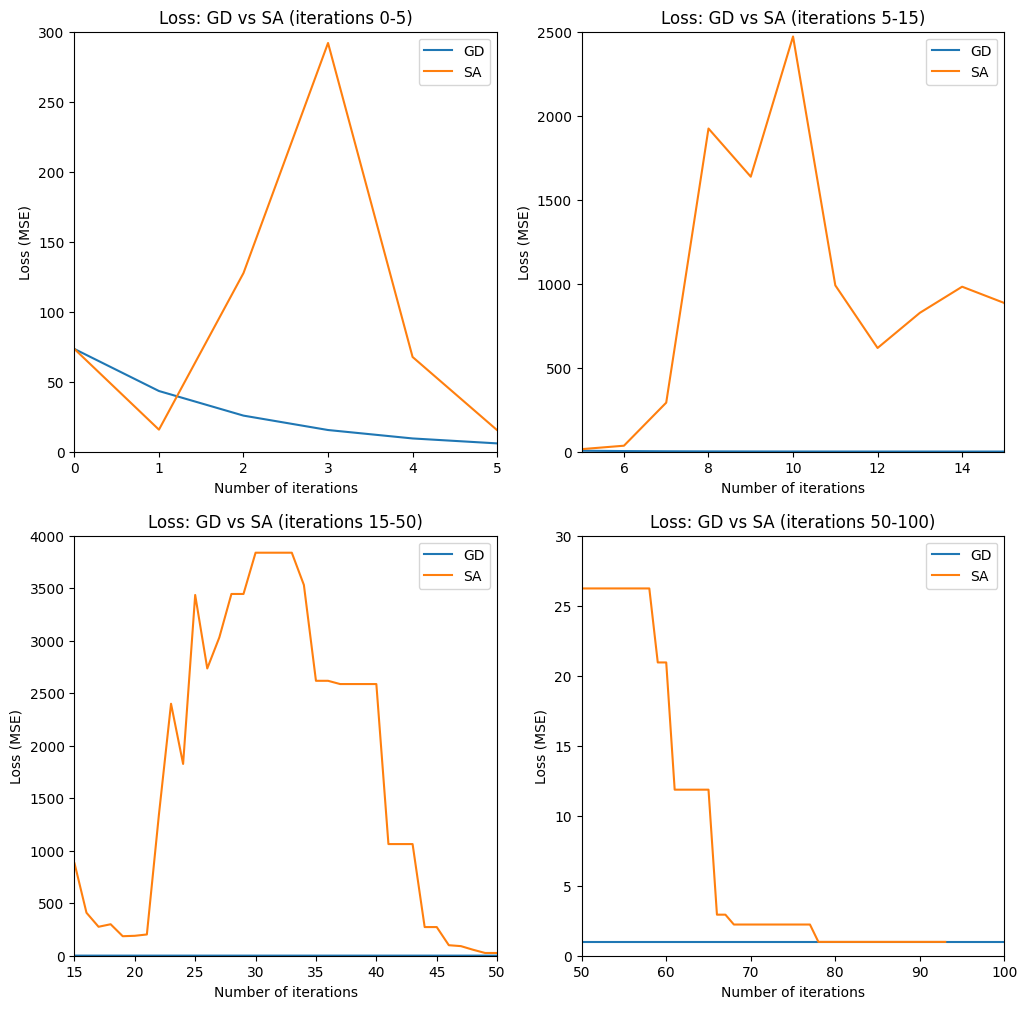

In [46]:
plt.figure(figsize=(12, 12))

ax = plt.subplot(2, 2, 1)
ax.plot(gd_loss, label='GD') 
ax.plot(sa_loss, label='SA')
ax.set_xlim(0, 5)
ax.set_ylim(0, 300)
ax.legend()
ax.set_title("Loss: GD vs SA (iterations 0-5)")
ax.set_xlabel("Number of iterations")
ax.set_ylabel("Loss (MSE)")

ax = plt.subplot(2, 2, 2)
ax.plot(gd_loss, label='GD') 
ax.plot(sa_loss, label='SA')
ax.set_xlim(5, 15)
ax.set_ylim(0, 2500)
ax.legend()
ax.set_title("Loss: GD vs SA (iterations 5-15)")
ax.set_xlabel("Number of iterations")
ax.set_ylabel("Loss (MSE)")

ax = plt.subplot(2, 2, 3)
ax.plot(gd_loss, label='GD') 
ax.plot(sa_loss, label='SA')
ax.set_xlim(15, 50)
ax.set_ylim(0, 4000)
ax.legend()
ax.set_title("Loss: GD vs SA (iterations 15-50)")
ax.set_xlabel("Number of iterations")
ax.set_ylabel("Loss (MSE)")

ax = plt.subplot(2, 2, 4)
ax.plot(gd_loss, label='GD') 
ax.plot(sa_loss, label='SA')
ax.set_xlim(50, 100)
ax.set_ylim(0, 30)
ax.legend()
ax.set_title("Loss: GD vs SA (iterations 50-100)")
ax.set_xlabel("Number of iterations")
ax.set_ylabel("Loss (MSE)")

plt.show();

Преимуществом алгоритма имитации отжига перед классическим градиентным спуском является дополнительное условие остановки: когда температура падает ниже критической, а не только при выполнении фиксированного числа итераций.

Также потенциально при имитации отжига проще "выскочить" из локального минимума функции потерь за счёт случайного выбора нового состояния. Однако при классическом лоссе MSE это не требуется (локальный минимум один и является глобальным), поэтому по траектории алгоритма и по последовательности значений лосса просто видно огромное количество неоптимальных изменений в параметрах модели по сравнению с классическим градиентным спуском.